# Keras implementation of the Deep Adaptive Input Normalization layer for Time Series Forecasting

https://arxiv.org/pdf/1902.07892.pdf

### Keras/Tensorflow implementation

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
plt.ion()

In [2]:
class Adaptive_Normalizer_Layer(tf.keras.layers.Layer):
    def __init__(self, mode = 'full', input_dim = 2):
        super(Adaptive_Normalizer_Layer, self).__init__()
        
        '''
        PARAMETERS
        
        :param mode: Type of normalization to be performed.
                        - 'adaptive_average' performs the adaptive average of the inputs
                        - 'adaptive_scale' performs the adaptive z-score normalization of the inputs
                        - 'full' (Default) performs the complete normalization process: adaptive_average + adaptive_scale + gating
        :param input_dim
        '''
        
        self.mode = mode
        self.x = None

        self.eps = 1e-8
        
        initializer = tf.keras.initializers.Identity()
        gate_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
        self.linear_1 = tf.keras.layers.Dense(input_dim, kernel_initializer=initializer, use_bias=False)
        self.linear_2 = tf.keras.layers.Dense(input_dim, kernel_initializer=initializer, use_bias=False)
        self.linear_3 = tf.keras.layers.Dense(input_dim, kernel_initializer=gate_initializer)

    def call(self, inputs):
        # Expecting (n_samples, dim, n_feature_vectors)
        
        def adaptive_avg(inputs):
        
            avg = tf.keras.backend.mean(inputs, 2)
            adaptive_avg = self.linear_1(avg)
            adaptive_avg = tf.keras.backend.reshape(adaptive_avg, (tf.shape(inputs)[0].numpy(), tf.shape(inputs)[1].numpy(), 1))
            x = inputs - adaptive_avg
            
            return x
        
        def adaptive_std(x):
        
            std = tf.keras.backend.mean(x ** 2, 2)
            std = tf.keras.backend.sqrt(std + self.eps)
            adaptive_std = self.linear_2(std)
            adaptive_std = tf.where(tf.math.less_equal(adaptive_std, self.eps), 1, adaptive_std)
            adaptive_std = tf.keras.backend.reshape(adaptive_std, (tf.shape(inputs)[0].numpy(), tf.shape(inputs)[1].numpy(), 1))
            x = x / (adaptive_std)
            
            return x
        
        def gating(x):
            
            gate = tf.keras.backend.mean(x, 2)
            gate = self.linear_3(gate)
            gate = tf.math.sigmoid(gate)
            gate = tf.keras.backend.reshape(gate, (tf.shape(inputs)[0].numpy(), tf.shape(inputs)[1].numpy(), 1))
            x = x * gate
            
            return x
        
        if self.mode == None:
            pass
        
        elif self.mode == 'adaptive_average':
            self.x = adaptive_avg(inputs)
            
        elif self.mode == 'adaptive_scale':
            self.x = adaptive_avg(inputs)
            self.x = adaptive_std(x)
            
        elif self.mode == 'full':
            self.x = adaptive_avg(inputs)
            self.x = adaptive_std(self.x)
            self.x = gating(self.x)
        
        else:
            assert False

        return self.x

In [3]:
def parse_data_1(filename):
    cols = ["unix", "open", "high", "low", "close", "volume", "tbqav", "tbbav", "qav", "noftrades"]
    data = pd.read_csv(filename, sep = "|", header=None, names = cols)
    data = data[["unix","open","low","close","high","volume"]]
    return data

def parse_daily(filename):
    data = pd.read_csv(filename)
    data = data[["Date", "Close/Last"]]
    data = data.rename(columns = {"Close/Last": "close", "Date":"unix"})
    return data[::-1]

def parse_binance_data(filename):
    # https://www.cryptodatadownload.com/data/binance/
    df = pd.read_csv(filename, skiprows = 1)[::-1]
    print(filename, "Size:", len(df))
    df = df[["unix", "close"]]
    return df
    
    #https://coinmetrics.io/community-network-data/

def compareminmax(df):
    print("Normal:", min(df.close),"=>",max(df.close))
    print("DAIN:", round(min(df.dain),4),"=>",round(max(df.dain),4))
    print("Normal meansd:", round(min(df.normal_meansd),4),"=>",round(max(df.normal_meansd),4))
    print("DAIN meansd:", round(min(df.dain_meansd),4),"=>",round(max(df.dain_meansd),4))

def minmax(col):
    return (col - col.min()) / (col.max() - col.min())

def meansd(col):
    return (col - col.mean())/col.std()

def add_meansd_minmax_to_df(df):
    df.loc[:,"dain_minmax"] = minmax(df.dain)
    df.loc[:,"dain_meansd"] = meansd(df.dain)
    df.loc[:,"normal_minmax"] = minmax(df.close)
    df.loc[:,"normal_meansd"] = meansd(df.close)
    return df
    
def add_dain_to_df(df, n ):
    example_tensor = tf.constant([[df.close]])
    keras_layer = Adaptive_Normalizer_Layer(input_dim = tf.shape(example_tensor)[1].numpy())
    output = np.array(keras_layer(example_tensor)[0][0])
    df.loc[:,"dain"] = output
    return df.tail(n)

def add_data_to_df(df, n):
    df = add_dain_to_df(df, n)
    df = add_meansd_minmax_to_df(df)
    return df

In [4]:
xrp = add_data_to_df(parse_binance_data("cryptodatadownload/Binance_XRPUSDT_d.csv"),200)
btc = add_data_to_df(parse_binance_data("cryptodatadownload/Binance_BTCUSDT_d.csv"),200)
ada = add_data_to_df(parse_binance_data("cryptodatadownload/Binance_ADAUSDT_d.csv"),200)
eth = add_data_to_df(parse_binance_data("cryptodatadownload/Binance_ETHUSDT_d.csv"),200)

cryptodatadownload/Binance_XRPUSDT_d.csv Size: 1272
cryptodatadownload/Binance_BTCUSDT_d.csv Size: 1533
cryptodatadownload/Binance_ADAUSDT_d.csv Size: 1289
cryptodatadownload/Binance_ETHUSDT_d.csv Size: 1533


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


### Min/Max before and after

#### XRP

In [5]:
compareminmax(xrp)

Normal: 0.5284 => 1.83468
DAIN: 0.1327 => 2.2847
Normal meansd: -1.7023 => 2.7422
DAIN meansd: -1.7023 => 2.7422


#### BTC

In [6]:
compareminmax(btc)

Normal: 29790.35 => 66001.41
DAIN: 0.4469 => 1.6036
Normal meansd: -1.6523 => 2.2085
DAIN meansd: -1.6523 => 2.2085


#### ADA

In [7]:
compareminmax(ada)

Normal: 1.0539 => 2.966
DAIN: 0.4866 => 1.9232
Normal meansd: -1.4287 => 2.2937
DAIN meansd: -1.4287 => 2.2937


#### ETH

In [8]:
compareminmax(eth)

Normal: 1786.03 => 4220.37
DAIN: 0.5544 => 1.8506
Normal meansd: -1.6944 => 2.0602
DAIN meansd: -1.6944 => 2.0602


### Normal close

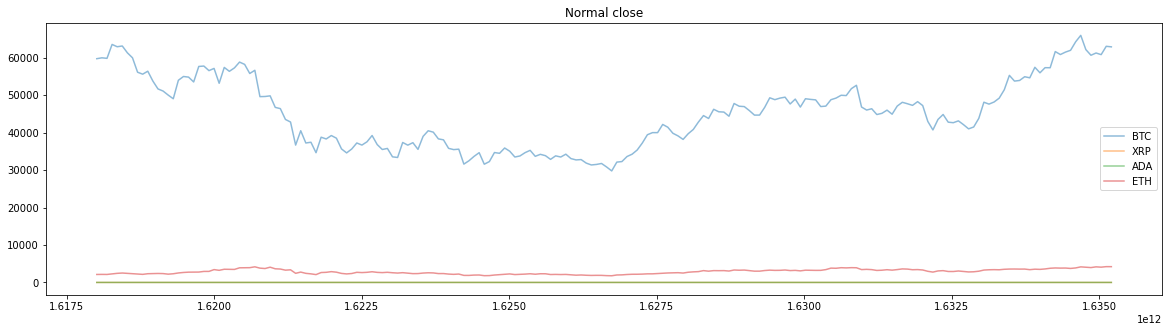

In [9]:
X = xrp.unix
plt.plot(X, btc.close, label = "BTC", alpha = 0.5)
plt.plot(X, xrp.close, label = "XRP", alpha = 0.5)
plt.plot(X, ada.close, label = "ADA", alpha = 0.5)
plt.plot(X, eth.close, label = "ETH", alpha = 0.5)

plt.title('Normal close')
plt.legend()
plt.show()

### DAIN close

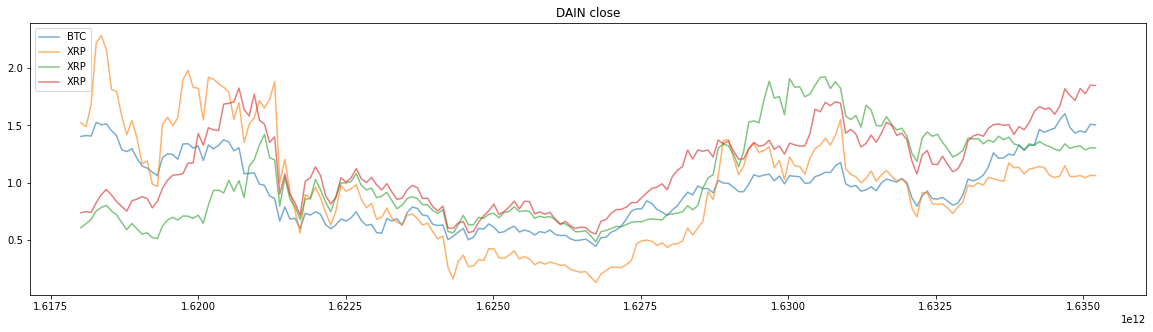

In [10]:
X = xrp.unix
plt.plot(X, btc.dain, label = "BTC", alpha = 0.6)
plt.plot(X, xrp.dain, label = "XRP", alpha = 0.6)
plt.plot(X, ada.dain, label = "XRP", alpha = 0.6)
plt.plot(X, eth.dain, label = "XRP", alpha = 0.6)

plt.title('DAIN close')
plt.legend()
plt.show()

### MINMAX(Normal) close

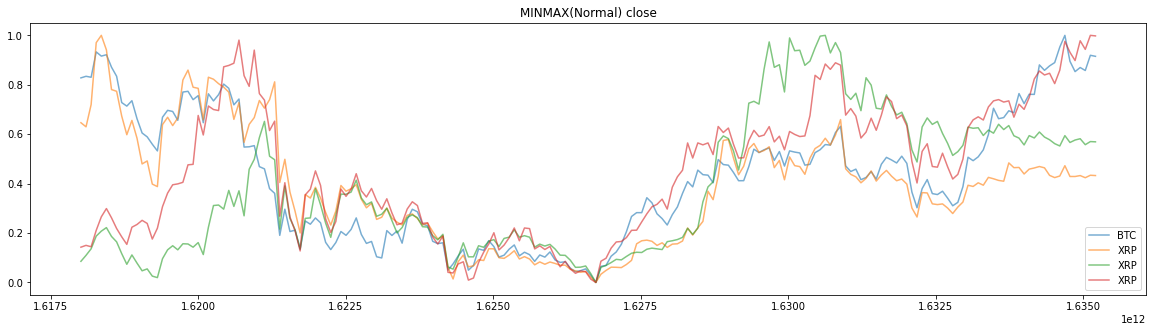

In [11]:
X = xrp.unix
plt.plot(X, btc.normal_minmax, label = "BTC", alpha = 0.6)
plt.plot(X, xrp.normal_minmax, label = "XRP", alpha = 0.6)
plt.plot(X, ada.normal_minmax, label = "XRP", alpha = 0.6)
plt.plot(X, eth.normal_minmax, label = "XRP", alpha = 0.6)

plt.title('MINMAX(Normal) close')
plt.legend()
plt.show()

### MINMAX(DAIN) close

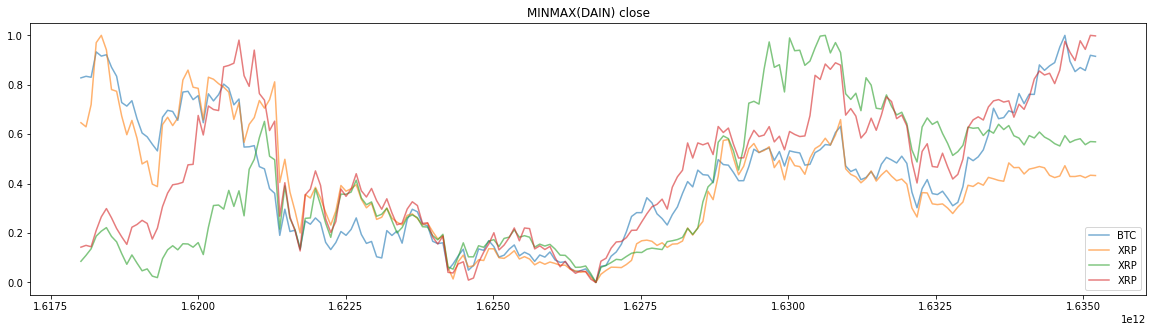

In [12]:
X = xrp.unix
plt.plot(X, btc.dain_minmax, label = "BTC", alpha = 0.6)
plt.plot(X, xrp.dain_minmax, label = "XRP", alpha = 0.6)
plt.plot(X, ada.dain_minmax, label = "XRP", alpha = 0.6)
plt.plot(X, eth.dain_minmax, label = "XRP", alpha = 0.6)

plt.title('MINMAX(DAIN) close')
plt.legend()
plt.show()

### MEANSD(Normal) close

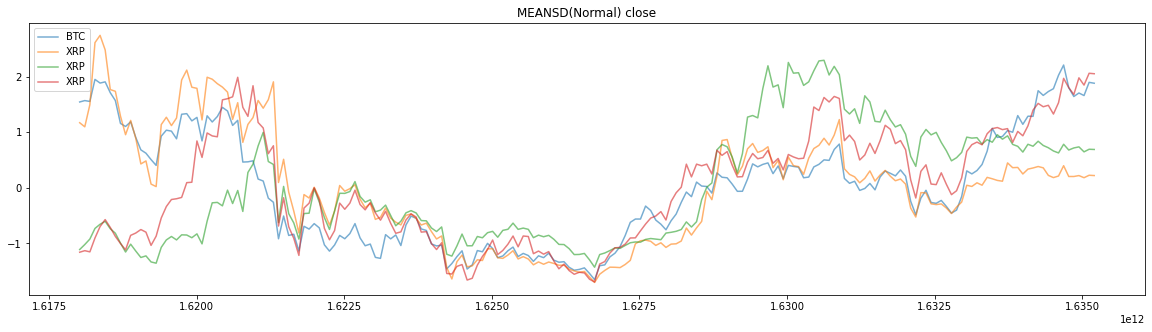

In [13]:
X = xrp.unix
plt.plot(X, btc.normal_meansd, label = "BTC", alpha = 0.6)
plt.plot(X, xrp.normal_meansd, label = "XRP", alpha = 0.6)
plt.plot(X, ada.normal_meansd, label = "XRP", alpha = 0.6)
plt.plot(X, eth.normal_meansd, label = "XRP", alpha = 0.6)

plt.title('MEANSD(Normal) close')
plt.legend()
plt.show()

### MEANSD(DAIN) close

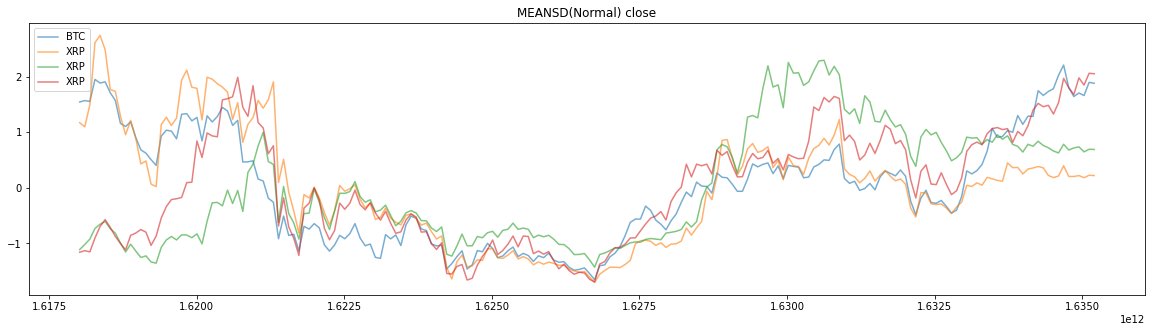

In [14]:
X = xrp.unix
plt.plot(X, btc.dain_meansd, label = "BTC", alpha = 0.6)
plt.plot(X, xrp.dain_meansd, label = "XRP", alpha = 0.6)
plt.plot(X, ada.dain_meansd, label = "XRP", alpha = 0.6)
plt.plot(X, eth.dain_meansd, label = "XRP", alpha = 0.6)

plt.title('MEANSD(Normal) close')
plt.legend()
plt.show()